# <center>Predicting Thyroid Disorders from Drinking Water Contaminants Using Machine Learning Regression Techniques</center>

coded by: K.M. Anderson

### Overview:

- supervised continous task
- predicting TT4 thyroid levels based on water contaminants and thyroid disease variables
- support vector regression, random forest regression, artificial neural network, CatBoost regression, XGBoost regression, and GradientBoost Regression

Using the causal-learn package for python. From this, I will be utilizing numpy, pandas, scikit-learn, and matplotlib.

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.array as da
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xg
import catboost as cb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR 
# from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import MultiTaskLassoCV, LassoCV, RidgeCV
from sklearn.decomposition import PCA



import warnings
warnings.simplefilter('ignore', category=UserWarning)
%matplotlib inline

# THYROID Dataframe

In [2]:
thyroid_df = pd.read_csv("hypothyroid.csv")

In [3]:
# thyroid_df = pd.read_csv("A Jupyter Notebook/Dissertation/hypothyroid.csv")
thyroid_df = thyroid_df.replace("?", np.nan)

In [4]:
thyroid_df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,NaN,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,NaN,f,NaN,f,NaN,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,NaN,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,NaN,f,NaN,f,NaN,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,NaN,SVI,P


In [5]:
row_count = thyroid_df.shape[0]

print(f"Number of rows in the Thyroid DataFrame: {row_count}")

Number of rows in the Thyroid DataFrame: 3772


### Preprocessing

In [6]:
#converting integer columns to float 
columns_to_convert = [
    'T4U', 'TSH', 'T3', 'TT4', 'FTI', 'TBG'
]

for column in columns_to_convert:
    thyroid_df[column] = thyroid_df[column].astype(float)

In [7]:
#converting categorical columns to integers
columns_to_convert = [
    'T4U measured', 'TSH measured', 'T3 measured', 'TT4 measured', 'FTI measured', 'TBG measured'
]

for column in columns_to_convert:
    thyroid_df[column] = thyroid_df[column].astype('category').cat.codes

Filling NA

In [8]:
#categorical
thyroid_df['age'] = thyroid_df["age"].fillna(thyroid_df['age'].mode()[0])
thyroid_df['sex'] = thyroid_df["sex"].fillna(thyroid_df['sex'].mode()[0])

In [9]:
#numerical
thyroid_df['TSH'] = thyroid_df["TSH"].fillna(thyroid_df['TSH'].mean())
thyroid_df['T3'] = thyroid_df["T3"].fillna(thyroid_df['T3'].mean())
thyroid_df['TT4'] = thyroid_df["TT4"].fillna(thyroid_df['TT4'].mean())
thyroid_df['T4U'] = thyroid_df["T4U"].fillna(thyroid_df['T4U'].mean())
thyroid_df['TBG'] = thyroid_df["TBG"].fillna(thyroid_df['TBG'].mean())
thyroid_df['FTI'] = thyroid_df["FTI"].fillna(thyroid_df['FTI'].mean())

### Selecting Thyroid Features

In [10]:
#converting every categorical column to numerical
columns_to_convert = [
    'age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'referral source', 'binaryClass'
]

for column in columns_to_convert:
    thyroid_df[column] = thyroid_df[column].astype('category').cat.codes

In [11]:
thyroid_df = thyroid_df.drop(['FTI measured', 'T4U measured', 'TBG measured', 'TBG'],axis=1)

In [12]:
thyroid_df.columns

Index(['age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH',
       'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U', 'FTI',
       'referral source', 'binaryClass'],
      dtype='object')

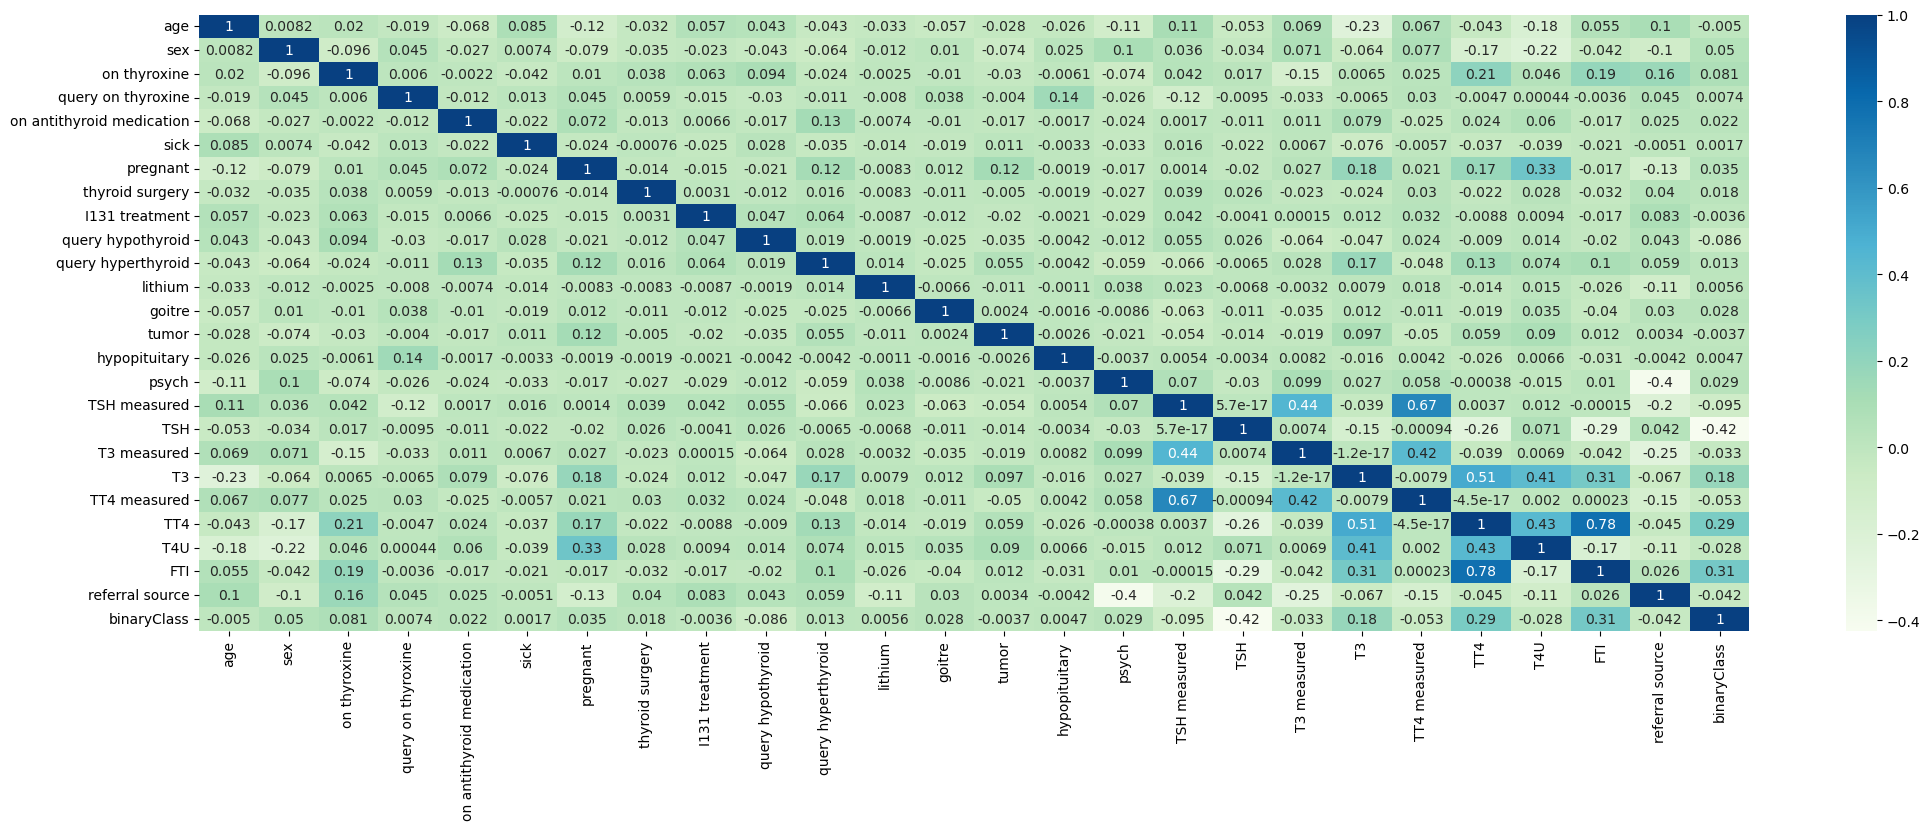

In [13]:
corr=thyroid_df.corr(numeric_only=True)
plt.figure(figsize=(25,8))
sns.heatmap(corr, annot = True, cmap="GnBu")
plt.show()

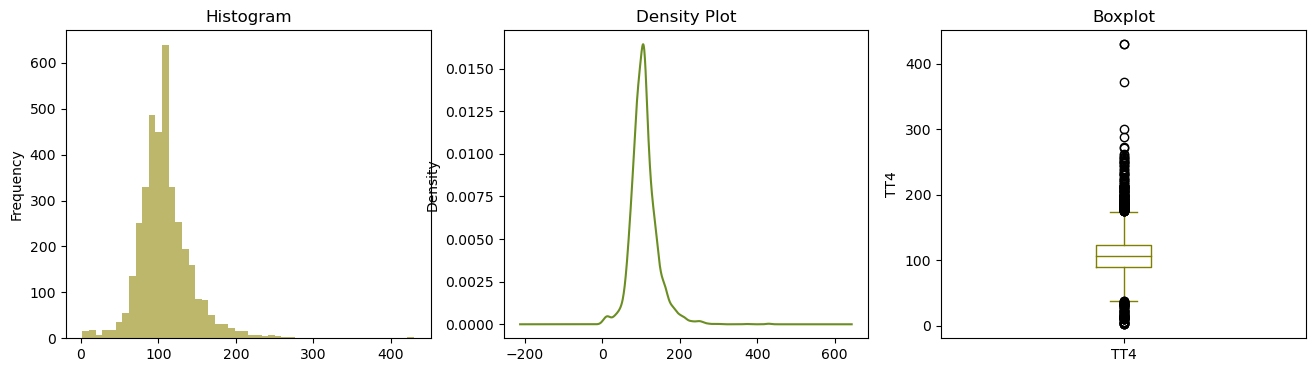

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
thyroid_df['TT4'].plot(kind='hist', color='darkkhaki',bins=50, ax=axes[0], xlabel="TT4",
                           title="Histogram")
thyroid_df['TT4'].plot(kind='density', color='olivedrab', ax=axes[1], title='Density Plot')
thyroid_df['TT4'].plot(kind='box', ax=axes[2], ylabel='TT4',
                           xlabel='', title='Boxplot', color='olive')
plt.show()

### Other Feature Selection Method

In [15]:
thyroid_df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U,FTI,referral source,binaryClass
0,34,0,0,0,0,0,0,0,0,0,...,1,1.30,1,2.5000,1,125.0,1.140,109.000000,1,1
1,15,0,0,0,0,0,0,0,0,0,...,1,4.10,1,2.0000,1,102.0,0.995,110.469649,4,1
2,40,1,0,0,0,0,0,0,0,0,...,1,0.98,0,2.0135,1,109.0,0.910,120.000000,4,1
3,67,0,1,0,0,0,0,0,0,0,...,1,0.16,1,1.9000,1,175.0,0.995,110.469649,4,1
4,67,0,0,0,0,0,0,0,0,0,...,1,0.72,1,1.2000,1,61.0,0.870,70.000000,3,1


In [16]:
#converting float columns back to numerical for the Feature Selection
columns_to_convert = [
    'T4U', 'TSH', 'T3', 'TT4', 'FTI'
]

for column in columns_to_convert:
    thyroid_df[column] = thyroid_df[column].astype('category').cat.codes

In [17]:
X = thyroid_df.drop(['TT4'],axis=1)
y = thyroid_df['TT4']

In [18]:
chi2 = SelectKBest(score_func = chi2, k = 'all').fit(X,y)
chi2_sorted = pd.Series(data=chi2.scores_, index=X.columns).sort_values()

ftest = SelectKBest(score_func = f_classif, k = 'all').fit(X,y)
ftest_sorted = pd.Series(data=ftest.scores_, index=X.columns).sort_values()

mitest = SelectKBest(score_func = mutual_info_classif, k = 'all').fit(X,y)
mitest_sorted = pd.Series(data=mitest.scores_, index=X.columns).sort_values()

#getting the red warning because there are negatives values?
xtrees = ExtraTreesClassifier().fit(X, y)
xtrees_sorted = pd.Series(data=xtrees.feature_importances_, index=X.columns).sort_values()

muinfo = mutual_info_classif(X,y)
muinfo_sorted = pd.Series(data=muinfo, index=X.columns).sort_values()

/Users/kaylaanderson/anaconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


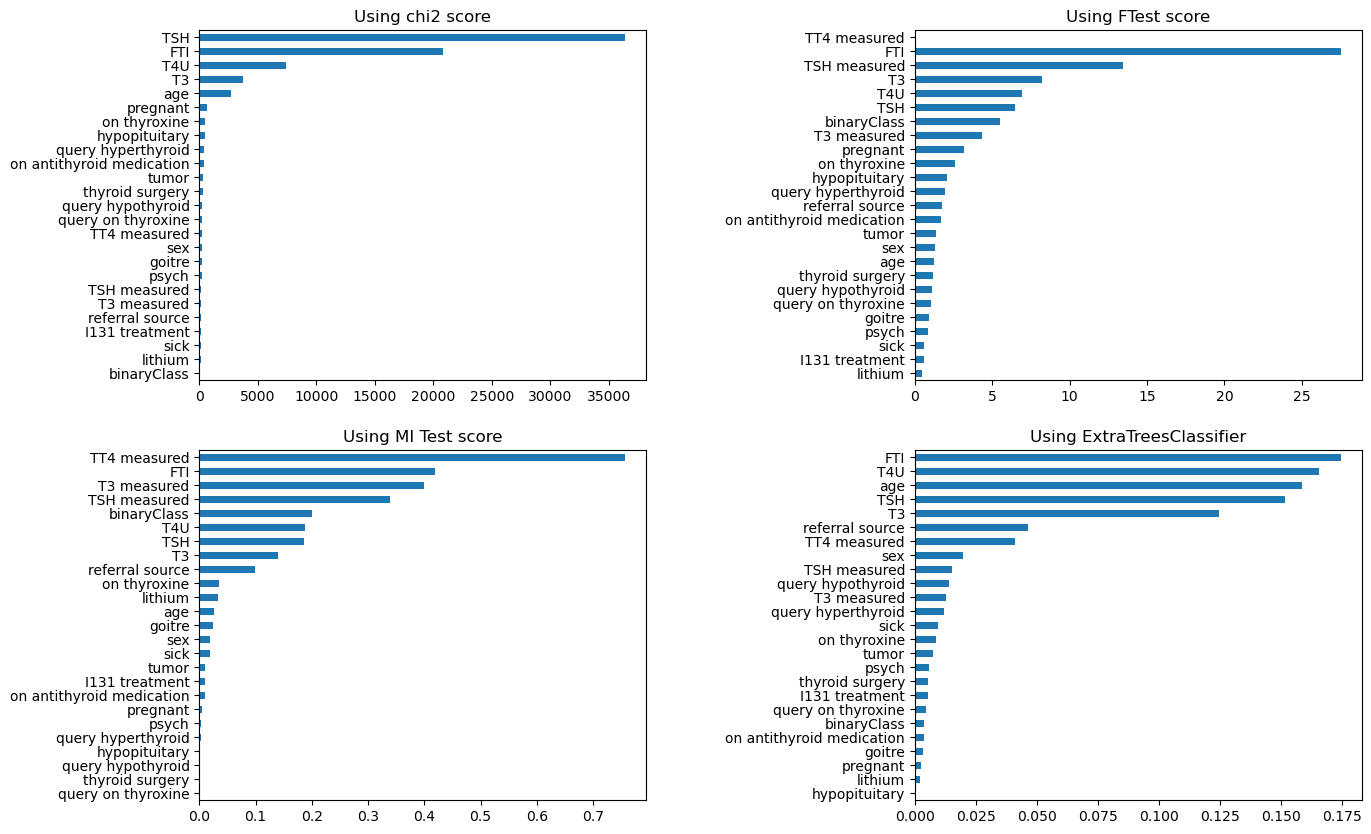

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.6)
chi2_sorted.plot(kind='barh', ax=axes[0, 0], title='Using chi2 score')
ftest_sorted.plot(kind='barh', ax=axes[0, 1], title='Using FTest score')
xtrees_sorted.plot(kind='barh', ax=axes[1, 1], title='Using ExtraTreesClassifier')
mitest_sorted.plot(kind='barh', ax=axes[1, 0], title='Using MI Test score')
plt.show()

In [20]:
thyroid_df = thyroid_df.drop(['referral source', 'binaryClass'], axis=1)

# Unregulated Contaminants

In [21]:
unreg_df = pd.read_csv("Unregulated Contaminants/ucmr_1/ucmr1_list.csv")

In [22]:
unreg_df.head()

,Contaminant,MRL,# of samples taken,PWS w Analyses,samples w/ a detection,PWS w Detects,min level detected,max level detected,average level detected
0,DCPA mono/di-acid degradate,1.0,"34,278","3,882",787,177,1.0,190.0,3.5
1,Molinate,0.9,"34,298","3,879",1,1,5.7,5.7,5.7
2,MTBE,5.0,"34,131","3,877",26,19,5.0,49.0,15.2
3,Nitrobenzene,10.0,"33,937","3,867",2,2,21.6,100.0,60.8
4,Perchlorate,4.0,"34,728","3,870",647,160,4.0,420.0,9.9


# Contaminant VIOLATIONS Dataframe

In [28]:
contam_counts_df = pd.read_csv("contaminantviolations.csv")
contam_counts_df

,CONTAMINANT_CODE,COUNT
0,3100,3141071
1,1040,735886
2,8000,607583
3,7500,398686
4,5000,366886
...,...,...
153,2392,3
154,2394,3
155,2396,3
156,2400,3


In [29]:
row_147 = contam_counts_df.iloc[147]
print(row_147)

CONTAMINANT_CODE    2***
COUNT                  8
Name: 147, dtype: object


In [30]:
contam_counts_df.drop(147, inplace=True)

## Tabling

In [31]:
contam_counts_df.value_counts()

CONTAMINANT_CODE  COUNT 
0100              2238      1
2962              144       1
2942              144       1
2943              147       1
2944              144       1
                           ..
2045              10        1
2046              57124     1
2047              20375     1
2050              68575     1
8000              607583    1
Length: 157, dtype: int64

In [32]:
pivot_df = contam_counts_df.pivot(index=None, columns='CONTAMINANT_CODE', values='COUNT')
contam_counts_df = pd.concat([contam_counts_df, pivot_df], axis=1)
contam_counts_df.reset_index(drop=True, inplace=True)

### NaN Handling and Standardization for Contaminant Dataset

In [33]:
contam_counts_df.fillna(0, inplace=True)
contam_counts_df.head()

,CONTAMINANT_CODE,COUNT,0100,0200,0300,0400,0500,0600,0700,0800,...,4030,4100,4101,4102,4174,4264,5000,7000,7500,8000
0,3100,3141071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1040,735886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8000,607583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,607583.0
3,7500,398686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,398686.0,0.0
4,5000,366886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,366886.0,0.0,0.0,0.0


Most of the rows have values of 0.0 but only some rows have significantly larger values. This means the data is highly skewed. The best normalization for this case would be the Box-Cox method.

### Box-Cox Standardization Scaling

In [34]:
columns_to_transform = ['0100', '0200', '0300', '0400', '0500', '0600', '0700', '0800', '0999', '1005', '1006', '1008', '1009', '1010', '1011', '1012', '1015', '1020', '1022', '1024', '1025', '1030', '1035', '1036', '1038', '1040', '1041', '1045', '1050', '1055', '1074', '1075', '1085', '1094', '2005', '2010', '2015', '2020', '2021', '2022', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2039', '2040', '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2050', '2051', '2063', '2065', '2066', '2067', '2070', '2076', '2077', '2105', '2110', '2201', '2210', '2214', '2216', '2251', '2257', '2265', '2274', '2298', '2306', '2326', '2356', '2378', '2380', '2383', '2388', '2390', '2392', '2394', '2396', '2398', '2400', '2408', '2410', '2412', '2413', '2414', '2416', '2440', '2456', '2595', '2920', '2931', '2941', '2942', '2943', '2944', '2946', '2950', '2955', '2959', '2962', '2964', '2965', '2966', '2967', '2968', '2969', '2976', '2977', '2978', '2979', '2980', '2981', '2982', '2983', '2984', '2985', '2986', '2987', '2988', '2989', '2990', '2991', '2992', '2993', '2995', '2996', '2997', '3000', '3002', '3013', '3014', '3015', '3028', '3100', '4000', '4006', '4010', '4020', '4030', '4100', '4101', '4102', '4174', '4264', '5000', '7000', '7500', '8000']  # List of columns to transform

for col in columns_to_transform:
    transformed_col, _ = boxcox(contam_counts_df[col].values + 1)  # Extract values using .values and add 1 to avoid issues with zero values
    contam_counts_df[col] = transformed_col

scaler = StandardScaler()
data_scaled = scaler.fit_transform(contam_counts_df)

In [35]:
contam_counts_df = contam_counts_df.drop(['CONTAMINANT_CODE', 'COUNT'], axis=1)

# MERGED Dataframe

In [36]:
thyroid_df['ID'] = range(len(thyroid_df))
contam_counts_df['ID'] = range(len(contam_counts_df))
df_merged = pd.concat([thyroid_df, contam_counts_df.drop('ID', axis=1)], axis=1)
df_merged.drop('ID', axis=1, inplace=True)

In [37]:
df_merged.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,4030,4100,4101,4102,4174,4264,5000,7000,7500,8000
0,34,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000
1,15,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000
2,40,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.084823
3,67,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.08214,0.000000
4,67,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.08161,0.0,0.00000,0.000000


## Variables Correlation w/ TT4 Barplot

### only contaminants w/ TT4

In [38]:
df_merged_contams = df_merged.drop(['age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
                                   'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
                                   'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych',
                                   'TSH measured', 'TSH', 'T3 measured', 'FTI','T3', 'TT4 measured', 'T4U'], axis=1)

In [39]:
X = df_merged_contams.drop(['TT4'], axis=1)
y = df_merged_contams['TT4'].values

In [40]:
df_combined = pd.DataFrame(X)
df_combined['TT4'] = y
correlations = df_combined.corr(numeric_only=True)['TT4'].drop('TT4')

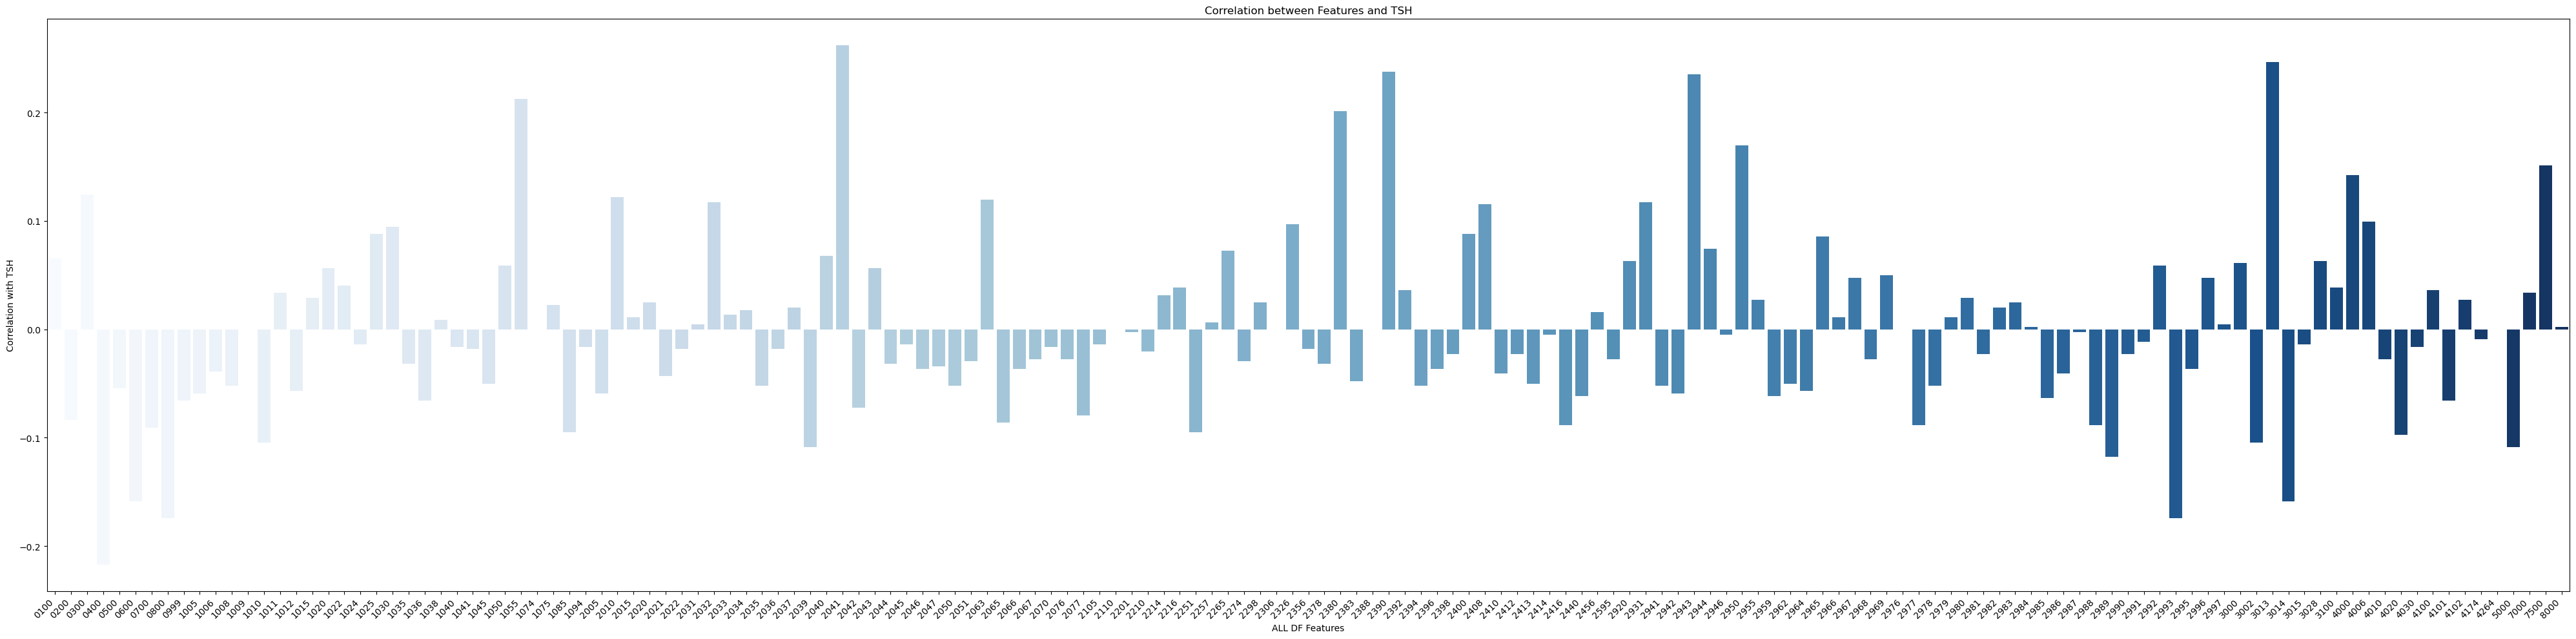

In [41]:
plt.figure(figsize=(40, 10))
sns.barplot(x=correlations.index, y=correlations.values, palette='Blues')
plt.xticks(rotation=45, ha="right")
plt.xlabel('ALL DF Features')
plt.ylabel('Correlation with TSH')
plt.title('Correlation between Features and TSH')
plt.tight_layout()
plt.show()

In [42]:
sorted_correlations = correlations.sort_values(ascending=False)
pd.set_option('display.max_rows', 45)
print("Top 45 Variables (contaminants only):\n\n",sorted_correlations[:45]) 

Top 45 Variables (contaminants only):

 2041    0.262273
3013    0.246432
2390    0.237380
2943    0.235117
1055    0.212488
2380    0.201173
2950    0.169491
7500    0.151388
4000    0.142336
0300    0.124232
2010    0.121969
2063    0.119706
2032    0.117443
2931    0.117443
2408    0.115180
4006    0.099340
2326    0.097077
1030    0.094814
2400    0.088025
1025    0.088025
2965    0.085762
2944    0.074447
2265    0.072184
2040    0.067658
0100    0.065395
3028    0.063132
2920    0.063132
3000    0.060869
2992    0.058606
1050    0.058606
1020    0.056343
2043    0.056343
2969    0.049555
2996    0.047292
2967    0.047292
1022    0.040503
3100    0.038240
2216    0.038240
2392    0.035977
4100    0.035977
7000    0.033714
1011    0.033714
2214    0.031451
2980    0.029188
1015    0.029188
Name: TT4, dtype: float64


#### Reference Codes Dictionary

In [43]:
code_ref = pd.read_csv("Regulated Contaminants/SDWA_REF_CODE_VALUES.csv")
code_ref.head()

,VALUE_TYPE,VALUE_CODE,VALUE_DESCRIPTION
0,ACTIVITY_CODE,A,Active
1,ACTIVITY_CODE,I,Inactive
2,ACTIVITY_CODE,N,Changed from public to non-public
3,ACTIVITY_CODE,M,Merged with another system
4,ACTIVITY_CODE,P,Potential future system to be regulated


In [44]:
contaminant_codes = code_ref[code_ref['VALUE_TYPE'] == 'CONTAMINANT_CODE']
columns_name = ['VALUE_TYPE', 'VALUE_CODE', 'VALUE_DESCRIPTION']
contam_ref_df = contaminant_codes[columns_name]

search by contaminant code number:

In [45]:
values_code_list = ['0100', '0300', '1020', '1025', '1030', '1050', '1055', '2010', '2032',
       '2040', '2041', '2043', '2063', '2265', '2326', '2380', '2390', '2400',
       '2408', '2920', '2931', '2943', '2944', '2950', '2965', '2967', '2969',
       '2992', '2996', '3000', '3013', '3028', '4000', '4006', '7500']
value_code_search = contaminant_codes[contaminant_codes['VALUE_CODE'].isin(values_code_list)]
columns_name = ['VALUE_TYPE', 'VALUE_CODE', 'VALUE_DESCRIPTION']
selected_values = value_code_search[columns_name]
print("Most violated contaminants:\n", selected_values['VALUE_DESCRIPTION'].tolist())

Most violated contaminants:
 ['BHC-GAMMA', 'Diquat', 'Picloram', 'Dinoseb', 'Aldicarb sulfoxide', '2,3,7,8-TCDD', 'Interim Enhanced Surface Water Treatment Rule', 'Turbidity', 'Chromium', 'Fluoride', 'Lead', 'Silver', 'Sulfate', 'Acrylamide', 'Pentachlorophenol', 'cis-1,2-Dichloroethylene', 'Aroclor 1221', 'Aroclor 1260', 'Dibromomethane', 'CARBON, TOTAL', '1,2-DIBROMO-3-CHLOROPROPANE', 'Bromodichloromethane', 'Dibromochloromethane', 'TTHM', 'o-Chlorotoluene', 'm-Dichlorobenzene', 'p-Dichlorobenzene', 'Ethylbenzene', 'Styrene', 'Coliform (Pre-TCR)', 'Fecal Coliform', 'COLIPHAGE', 'Gross Alpha, Excl. Radon and U', 'Combined Uranium', 'Public Notice']


### all features w/ TT4

In [46]:
X = df_merged.drop(['TT4'], axis=1)
y = df_merged['TT4'].values

In [47]:
df_combined = pd.DataFrame(X)
df_combined['TT4'] = y

correlations = df_combined.corr(numeric_only=True)['TT4'].drop('TT4')

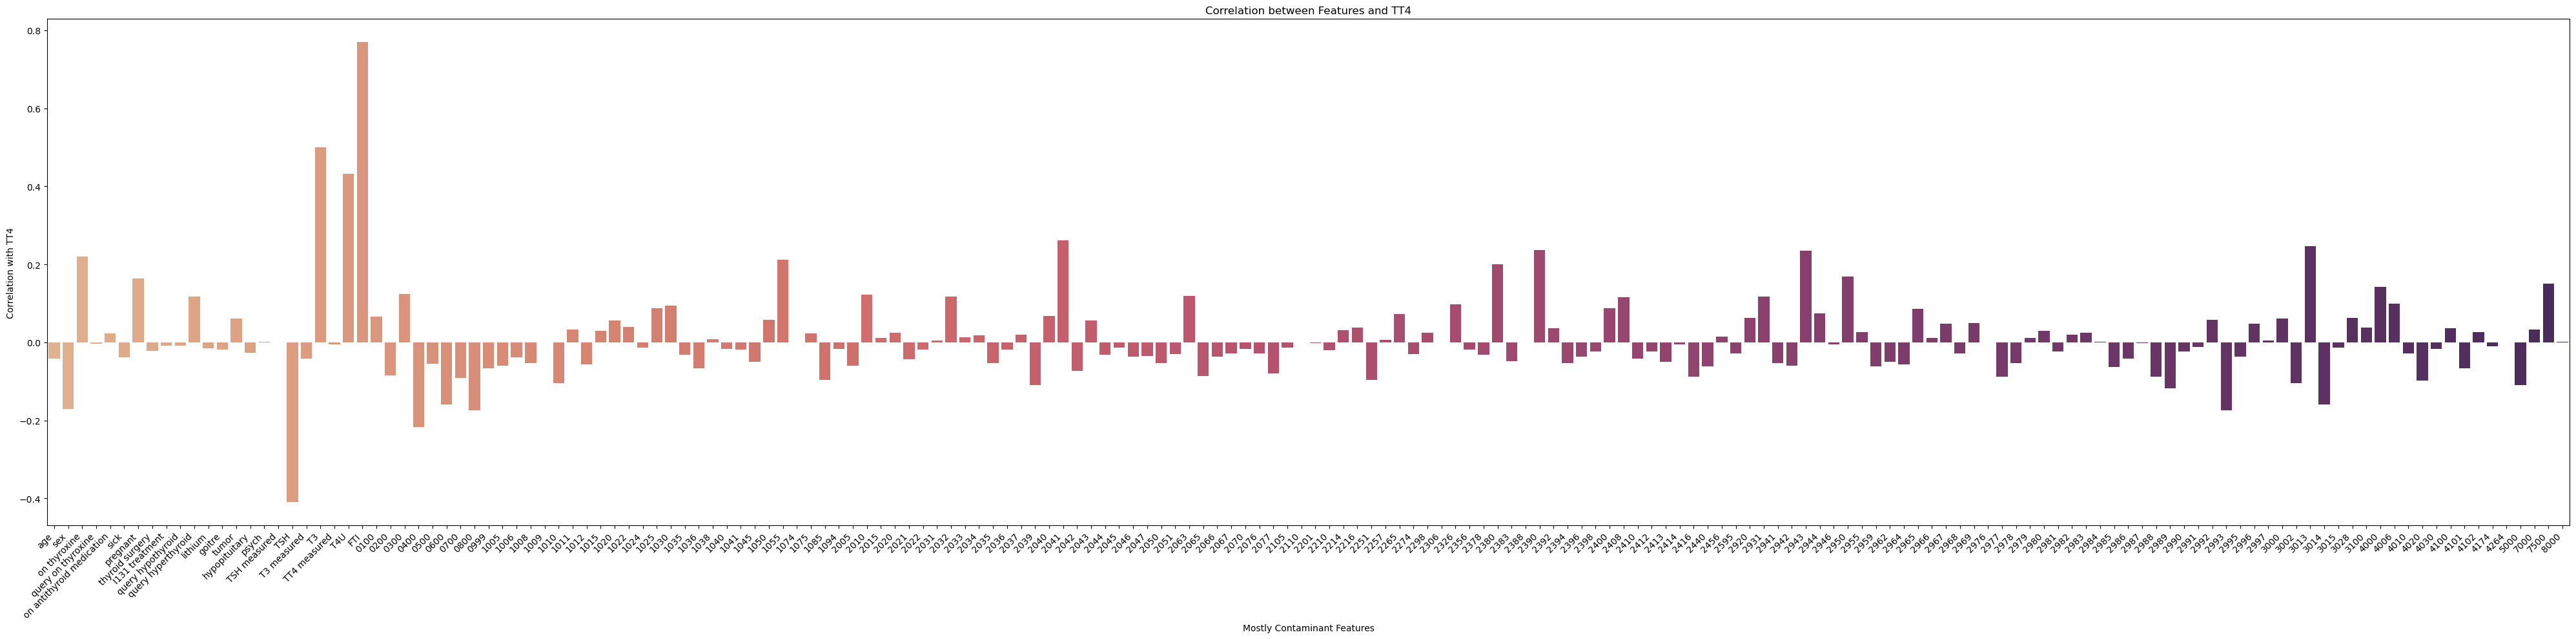

In [48]:
plt.figure(figsize=(40, 10))
sns.barplot(x=correlations.index, y=correlations.values, palette='flare')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Mostly Contaminant Features')
plt.ylabel('Correlation with TT4')
plt.title('Correlation between Features and TT4')
plt.tight_layout()
plt.show()

now getting rid of most features besides largely correlated ones (in descending order)

In [49]:
sorted_correlations = correlations.sort_values(ascending=False)
pd.set_option('display.max_rows', None)
print("Top 45 Variables (all variables from both datasets):\n\n", sorted_correlations[:45]) 

Top 45 Variables (all variables from both datasets):

 FTI                   0.770196
T3                    0.500070
T4U                   0.432598
2041                  0.262273
3013                  0.246432
2390                  0.237380
2943                  0.235117
on thyroxine          0.220094
1055                  0.212488
2380                  0.201173
2950                  0.169491
pregnant              0.164199
7500                  0.151388
4000                  0.142336
0300                  0.124232
2010                  0.121969
2063                  0.119706
query hyperthyroid    0.117628
2032                  0.117443
2931                  0.117443
2408                  0.115180
4006                  0.099340
2326                  0.097077
1030                  0.094814
2400                  0.088025
1025                  0.088025
2965                  0.085762
2944                  0.074447
2265                  0.072184
2040                  0.067658
0100           

In [50]:
columns_to_exclude = [
    'FTI', 'T3', 'T4U', 'on thyroxine', '2041', '3013', '2390', '2943',
    'query hyperthyroid', '1055', '2380', '2950', '7500', '4000', '0300',
    '2010', '2063', '2032', '2931', '2408', '4006', '2326', '1030', '2400',
    '1025', '2965', '2944', '2265', '2040', '0100', '3028', '2920',
    'on antithyroid medication', '3000', '2992', '1050', '1020', '2043',
    '2969', '2996', '2967', 'TSH measured', 'pregnant', 'TT4']

selected_columns = [col for col in df_merged.columns if col not in columns_to_exclude]
print("Variables to be dropped list:\n\n", selected_columns)

Variables to be dropped list:

 ['age', 'sex', 'query on thyroxine', 'sick', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3 measured', 'TT4 measured', '0200', '0400', '0500', '0600', '0700', '0800', '0999', '1005', '1006', '1008', '1009', '1010', '1011', '1012', '1015', '1022', '1024', '1035', '1036', '1038', '1040', '1041', '1045', '1074', '1075', '1085', '1094', '2005', '2015', '2020', '2021', '2022', '2031', '2033', '2034', '2035', '2036', '2037', '2039', '2042', '2044', '2045', '2046', '2047', '2050', '2051', '2065', '2066', '2067', '2070', '2076', '2077', '2105', '2110', '2201', '2210', '2214', '2216', '2251', '2257', '2274', '2298', '2306', '2356', '2378', '2383', '2388', '2392', '2394', '2396', '2398', '2410', '2412', '2413', '2414', '2416', '2440', '2456', '2595', '2941', '2942', '2946', '2955', '2959', '2962', '2964', '2966', '2968', '2976', '2977', '2978', '2979', '2980', '2981', '2982', '2983', '29

# Machine Learning Algorithms 
(<u>before</u> fine tuning variables)

### Support Vector Regression w/ JUST contaminants

In [51]:
df_merged_contams.dropna(inplace=True)
X = df_merged_contams.drop(['TT4'],axis=1)
y = df_merged_contams['TT4'].values
noise = np.random.normal(loc=0, scale=1, size=y.shape)
y = y + noise

In [52]:
def train_and_evalSVR(model, X, y):
    print('\nResults from algorithm {}:'.format(model))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    
    svr = SVR(kernel='rbf', C=40.0, epsilon=0.1)
   
    model = svr.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    print("R2 Score: {:.2f}".format(r2))
    return model
svr_model = SVR()
results = train_and_evalSVR(svr_model, X, y)


Results from algorithm SVR():
Mean Squared Error: 1194.42
Mean cross-validation RMSE is 37.245 with SD 561.006
R2 Score: -0.48


### Support Vector Regression w/ ALL variables from merged dataset

In [53]:
df_merged.dropna(inplace=True)
X = df_merged.drop(['TT4'],axis=1)
y = df_merged['TT4'].values
noise = np.random.normal(loc=0, scale=1, size=y.shape)
y = y + noise

In [54]:
def train_and_evalSVR(model, X, y):
    print('\nResults from algorithm {}:'.format(model))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    
    svr = SVR(kernel='rbf', C=40.0, epsilon=0.1)
    model = svr.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    print("R2 Score: {:.2f}".format(r2))
    return model
svr_model = SVR()
results = train_and_evalSVR(svr_model, X, y)


Results from algorithm SVR():
Mean Squared Error: 67.64
Mean cross-validation RMSE is 12.060 with SD 130.324
R2 Score: 0.92


results are good but lets try refining the dataset even further

### Refining Dataframe Variables for Better Results

In [55]:
df_merged_refined = df_merged.drop(['age', 'sex', 'query on thyroxine', 'sick', 'thyroid surgery', 'I131 treatment', 
                                    'query hypothyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 
                                    'T3 measured', 'TT4 measured', '0200', '0400', '0500', '0600', '0700', 
                                    '0800', '0999', '1005', '1006', '1008', '1009', '1010', '1011', '1012', '1015', 
                                    '1022', '1024', '1035', '1036', '1038', '1040', '1041', '1045', '1074', '1075', 
                                    '1085', '1094', '2005', '2015', '2020', '2021', '2022', '2031', '2033', '2034', 
                                    '2035', '2036', '2037', '2039', '2042', '2044', '2045', '2046', '2047', '2050', 
                                    '2051', '2065', '2066', '2067', '2070', '2076', '2077', '2105', '2110', '2201', 
                                    '2210', '2214', '2216', '2251', '2257', '2274', '2298', '2306', '2356', '2378', 
                                    '2383', '2388', '2392', '2394', '2396', '2398', '2410', '2412', '2413', '2414', 
                                    '2416', '2440', '2456', '2595', '2941', '2942', '2946', '2955', '2959', '2962', 
                                    '2964', '2966', '2968', '2976', '2977', '2978', '2979', '2980', '2981', '2982', 
                                    '2983', '2984', '2985', '2986', '2987', '2988', '2989', '2990', '2991', '2993', 
                                    '2995', '2997', '3002', '3014', '3015', '3100', '4010', '4020', '4030', '4100', 
                                    '4101', '4102', '4174', '4264', '5000', '7000', '8000'], axis=1)

In [56]:
df_merged_refined.columns

Index(['on thyroxine', 'on antithyroid medication', 'pregnant',
       'query hyperthyroid', 'TSH measured', 'TSH', 'T3', 'TT4', 'T4U', 'FTI',
       '0100', '0300', '1020', '1025', '1030', '1050', '1055', '2010', '2032',
       '2040', '2041', '2043', '2063', '2265', '2326', '2380', '2390', '2400',
       '2408', '2920', '2931', '2943', '2944', '2950', '2965', '2967', '2969',
       '2992', '2996', '3000', '3013', '3028', '4000', '4006', '7500'],
      dtype='object')

This refined dataframe allows so that additional testing doesnt have to be done, saving costs for medical providers.
- 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych','TSH', 'T3 measured', 'TT4 measured' are tests that do NOT need to be performed to predict TT4 levels
- Unfortunately cannot get rid of T3, T4U, or FTI tests

# Machine Learning Algorithms 
(<u>after</u> fine tuning variables)

In [57]:
X = df_merged_refined.drop(['TT4'],axis=1)
y = df_merged_refined['TT4'].values

In [58]:
noise = np.random.normal(loc=0, scale=1, size=len(y))
y = y + noise

## Support Vector Regression

In [59]:
def train_and_evalSVR(model, X, y):
    print('\nResults from algorithm:')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    
    svr = SVR(kernel='rbf', C=40.0, epsilon=0.1)
    
    model = svr.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    print("R2 Score: {:.2f}".format(r2))
    
    plt.figure(figsize=(15, 6))  
    plt.scatter(y_test, y_pred, color='deeppink', label='Actual SVR Model')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='darkslategrey', label='Predicted SVR Model', linewidth=2)
    plt.title('Support Vector Regression')
    plt.xlabel('Actual TT4 Levels')
    plt.ylabel('Predicted TT4 Levels')
    plt.legend()
    plt.show()

    return model


Results from algorithm:
Mean Squared Error: 53.02
Mean cross-validation RMSE is 12.065 with SD 138.251
R2 Score: 0.93


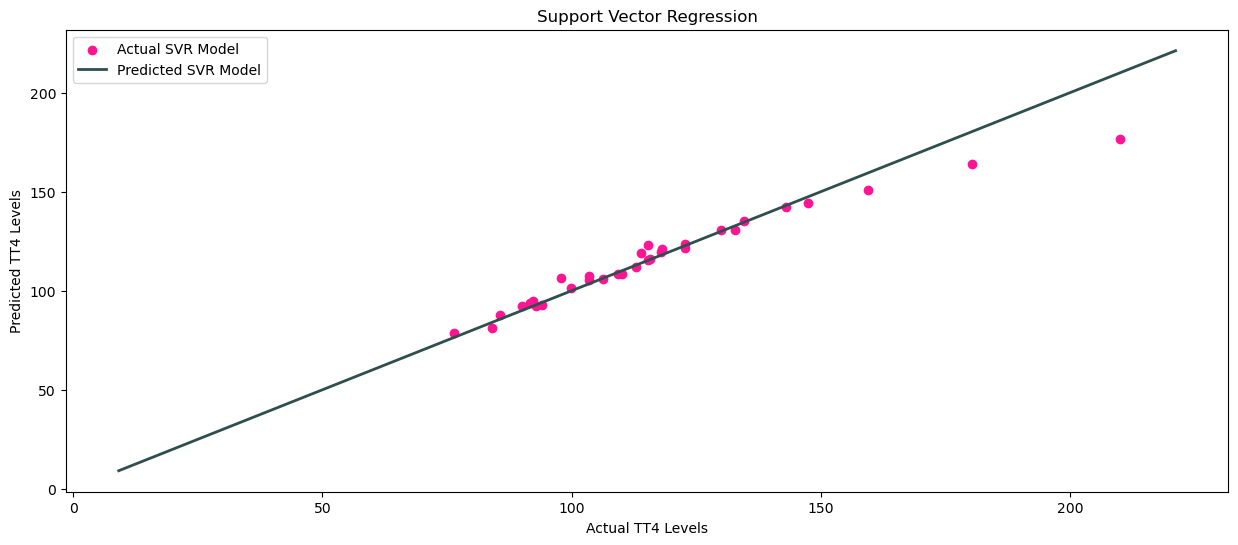

In [60]:
svr_model = SVR()
results = train_and_evalSVR(svr_model, X, y)

## Random Forest Regression

In [61]:
def train_and_evalRFR(model, X, y):
    print('\nResults from algorithm:\n')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

    RFR = RandomForestRegressor(n_estimators=100, random_state=64)
    
    model = RFR.fit(X_train, y_train)
    y_pred = model.predict(X_test)
   
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    print("R2 Score: {:.2f}".format(r2))

    plt.figure(figsize=(15, 6))
    plt.scatter(y_test, y_pred, color='forestgreen', alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='lightslategrey', linewidth=2)
    plt.title('Random Forest Regression')
    plt.xlabel('Actual TT4 Levels')
    plt.ylabel('Predicted TT4 Levels')
    plt.show()
    return model


Results from algorithm:

Mean Squared Error: 108.64
Mean cross-validation RMSE is 14.840 with SD 163.866
R2 Score: 0.86


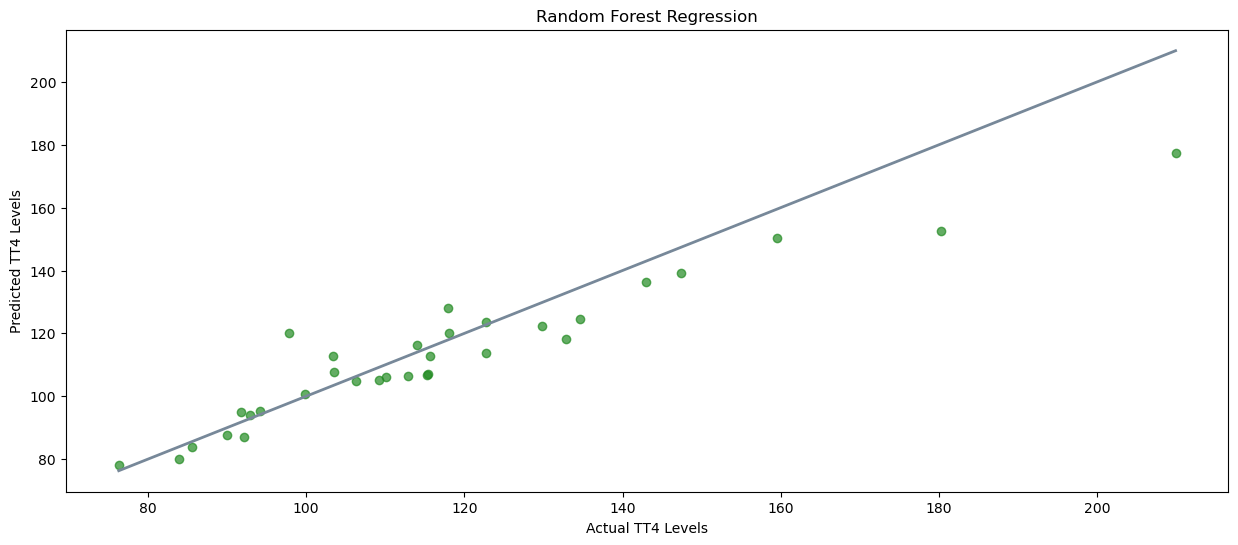

In [62]:
RFR_model = RandomForestRegressor(n_estimators=100, random_state=64)
results = train_and_evalRFR(RFR_model, X, y)

## Artificial Neural Network Regression

In [63]:
def train_and_evalANN(model, X, y):
    print('\nResults from algorithm:\n')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=64)

    ANN = MLPRegressor(random_state=64, max_iter=500)
    
    model = ANN.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    print("R2 Score: {:.2f}".format(r2))

    plt.figure(figsize=(15, 6))
    plt.scatter(y_test, y_pred, color='firebrick', alpha=0.7, label='Actual ANN Model')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='lightslategrey', label='Predicted ANN Model', linewidth=2)
    plt.title('Artificial Neural Network Regression')
    plt.xlabel('Actual TT4 Levels')
    plt.ylabel('Predicted TT4 Levels')
    plt.legend()
    plt.show()
    return model


Results from algorithm:

Mean Squared Error: 56.98
Mean cross-validation RMSE is 11.814 with SD 84.216
R2 Score: 0.93


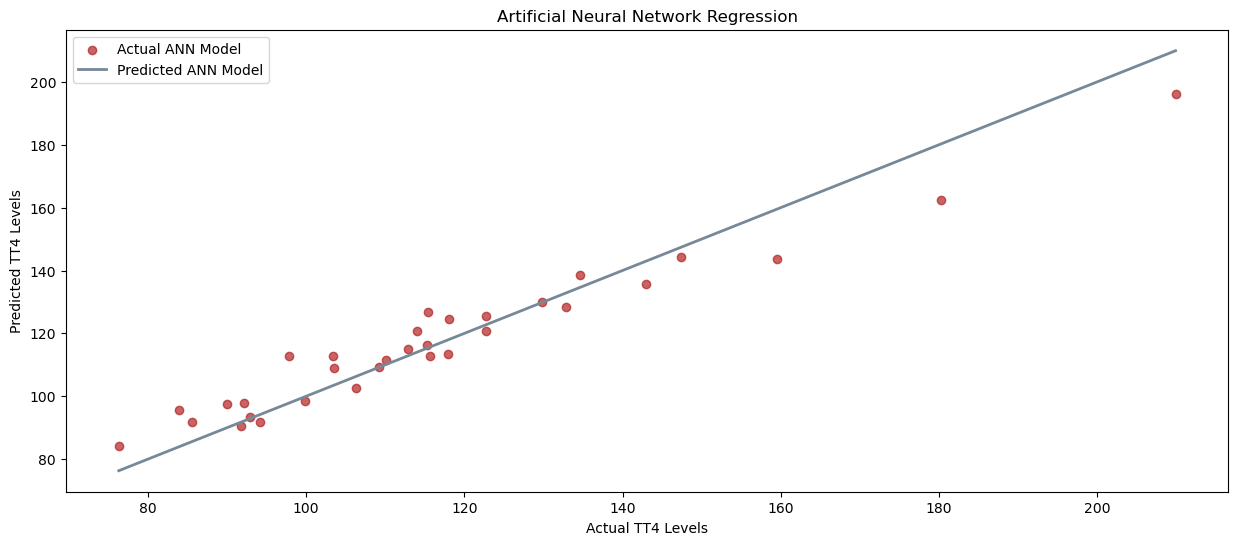

In [64]:
ANN_model = MLPRegressor()
results = train_and_evalANN(ANN_model, X, y)

## CatBoost Regression

In [65]:
def train_and_evalCB(model, X, y):
    print('\nResults from algorithm:\n')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    
    CatBoost = CatBoostRegressor(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        verbose=False)
    
    model = CatBoost.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    print("R2 Score: {:.2f}".format(r2))

    plt.figure(figsize=(15, 6))
    plt.scatter(y_test, y_pred, color='dodgerblue', alpha=0.7, label='Actual CatBoostRegressor Model')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='lightslategrey', label='Predicted CatBoostRegressor Model', linewidth=2)
    plt.title('CatBoost Regression')
    plt.xlabel('Actual TT4 Levels')
    plt.ylabel('Predicted TT4 Levels')
    plt.show()
    return model


Results from algorithm:

Mean Squared Error: 143.29
Mean cross-validation RMSE is 14.338 with SD 145.587
R2 Score: 0.82


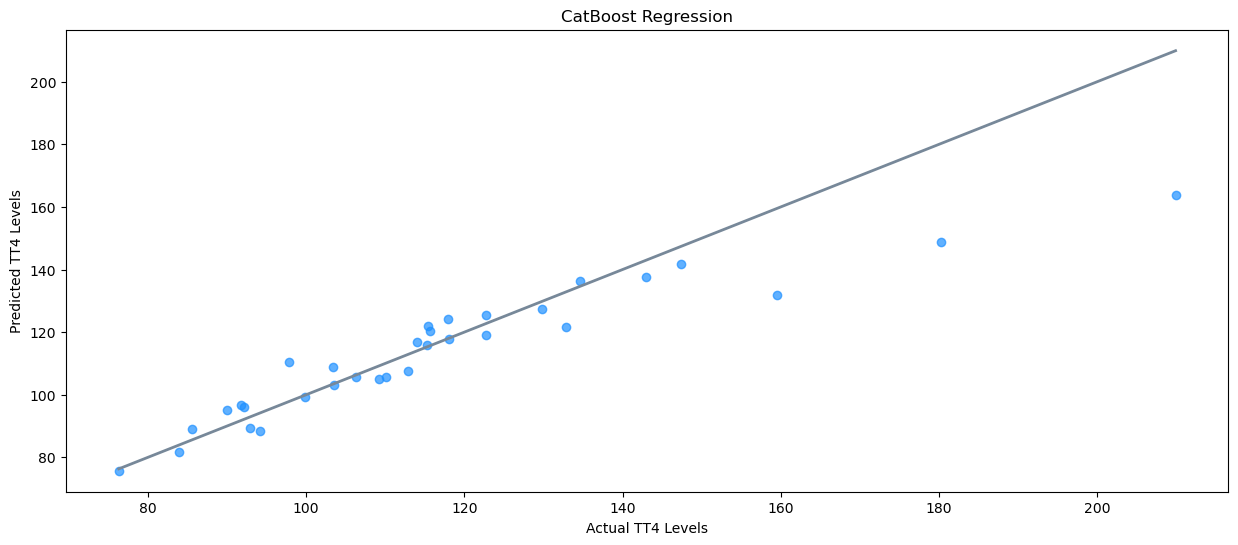

In [66]:
CatB_model = CatBoostRegressor()
results = train_and_evalCB(CatB_model, X, y)

## XGboost Regression

In [67]:
def train_and_evalXGB(model, X, y):
    print('\nResults from algorithm:\n')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    
    xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_child_weight=5,
        gamma=1,
        subsample=0.5,
        colsample_bytree=1,
        objective='reg:squarederror')
    
    model = xgb.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    print("R2 Score: {:.2f}".format(r2))
        
        
    plt.figure(figsize=(15, 6))  
    plt.scatter(y_test, y_pred, color='fuchsia', label='Actual XGBoostRegressor Model')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='darkslategrey', label='Predicted XGBoostRegressor Model', linewidth=2)
    plt.title('XGBoost Regression')
    plt.xlabel('Actual TT4 Levels')
    plt.ylabel('Predicted TT4 Levels')
    plt.legend()
    plt.show()

    return model


Results from algorithm:

Mean Squared Error: 97.88
Mean cross-validation RMSE is 15.157 with SD 235.739
R2 Score: 0.87


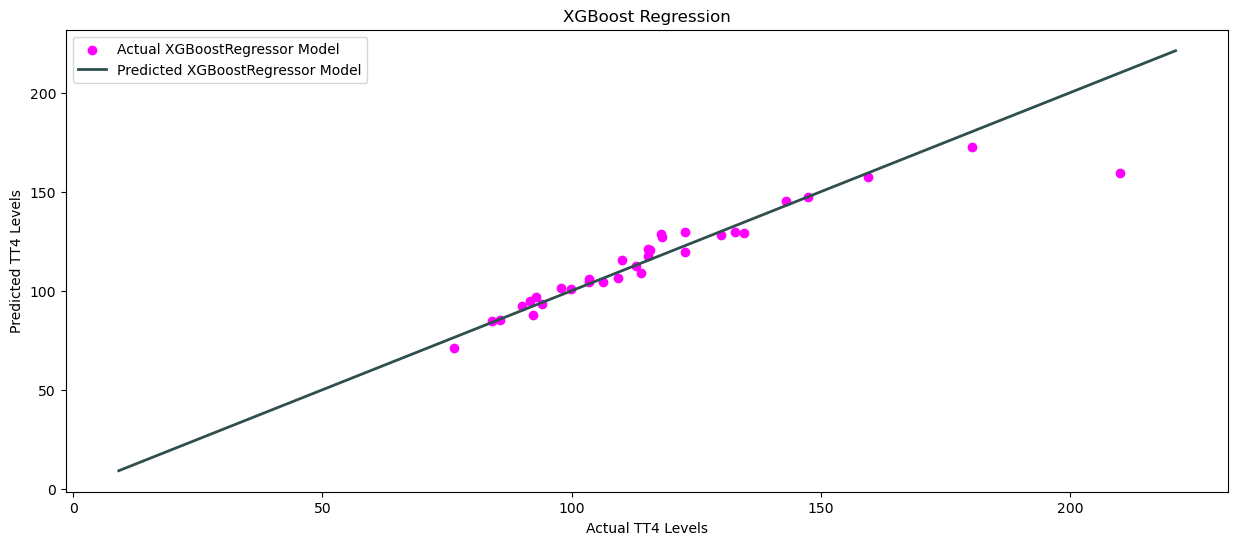

In [68]:
XGB_model = XGBRegressor()
results = train_and_evalXGB(XGB_model, X, y)

## GradientBoost Regression

In [69]:
def train_and_evalGBR(model, X, y):
    print('\nResults from algorithm:\n')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    
    gbr = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=2,
        verbose=0)
    
    model = gbr.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    sd = np.sqrt(np.var(scores))

    print("Mean Squared Error: {:.2f}".format(mse))
    print("Mean cross-validation RMSE is {:.3f} with SD {:.3f}".format(rmse, sd))
    print("R2 Score: {:.2f}".format(r2))


    plt.figure(figsize=(15, 6))  
    plt.scatter(y_test, y_pred, color='palevioletred', label='Actual GradientBoostingRegressor Model')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='lightslategrey', label='Predicted GradientBoostingRegressor Model', linewidth=2)
    plt.title('Gradient Boosting Regression')
    plt.xlabel('Actual TT4 Levels')
    plt.ylabel('Predicted TT4 Levels')
    plt.legend()
    plt.show()

    return model


Results from algorithm:

Mean Squared Error: 69.05
Mean cross-validation RMSE is 12.942 with SD 126.145
R2 Score: 0.91


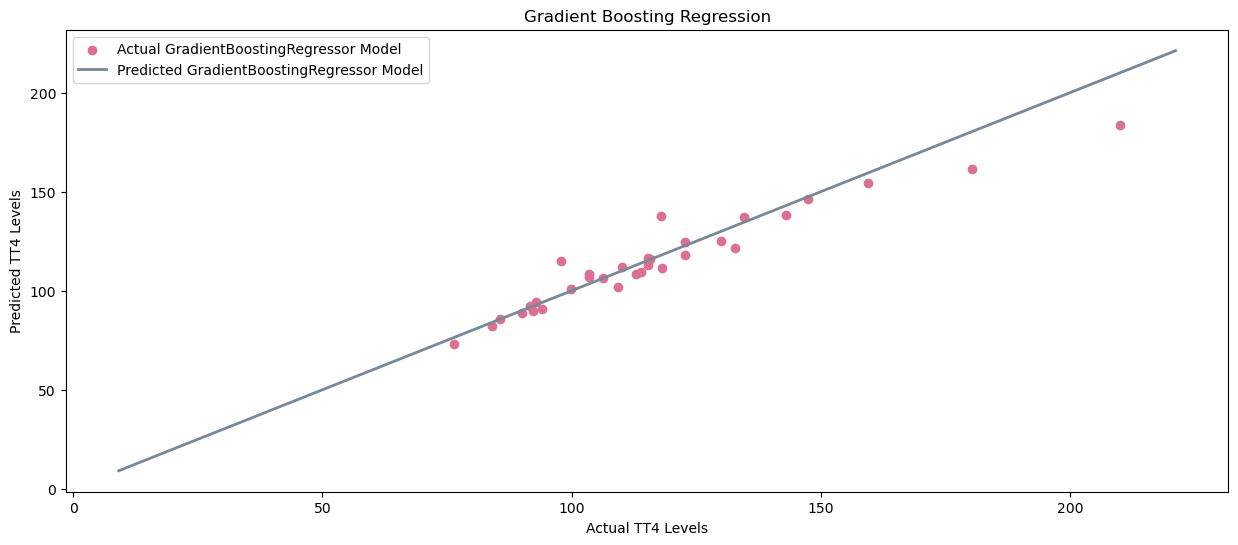

In [70]:
GBR_model = GradientBoostingRegressor()
results = train_and_evalGBR(GBR_model, X, y)